# Vanilla LSTM with CuPy

This is a port of [Vanilla LSTM with numpy](http://blog.varunajayasiri.com/numpy_lstm.html) that shows how to run the numpy-based machine learning code on GPU using CuPy.

This 

## Download data

In [1]:
%%bash
curl -L -O http://cs.stanford.edu/people/karpathy/char-rnn/shakespear.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 99993  100 99993    0     0   131k      0 --:--:-- --:--:-- --:--:--  159k


## Imports

In [2]:
import numpy as np
import cupy as cp
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

## Read and process data

In [3]:
data = open('shakespear.txt', 'r').read()

#### Process data and calculate indexes

In [4]:
chars = list(set(data))
data_size, X_size = len(data), len(chars)
print("data has %d characters, %d unique" % (data_size, X_size))
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

data has 99993 characters, 62 unique


## Parameters

In [5]:
H_size = 100 # Size of the hidden layer
T_steps = 25 # Number of time steps (length of the sequence) used for training
learning_rate = 1e-1 # Learning rate
weight_sd = 0.1 # Standard deviation of weights for initialization
z_size = H_size + X_size # Size of concatenate(H, X) vector

## Activation Functions and Derivatives

### Sigmoid

$$
\begin{eqnarray}
\sigma(x) &=& \frac{1}{1 + e^{-x}} \\
\frac{d \sigma(x)}{d x} &=& \sigma(x) \cdot (1 - \sigma(x))
\end{eqnarray}
$$

### Tanh

$$
\frac{d \tanh(x)}{dx} = 1 - \tanh^2(x)
$$

In [6]:
def sigmoid(x):
    return 1 / (1 + cp.exp(-x))


def dsigmoid(y):
    return y * (1 - y)


def tanh(x):
    return cp.tanh(x)


def dtanh(y):
    return 1 - y * y

## Initialize weights

We use random weights with normal distribution `(0, weight_sd)` for `tanh` activation function and `(0.5, weight_sd)` for `sigmoid` activation function.

Biases are initialized to zeros.

Formulae for LSTM are shown below.

In [7]:
W_f = cp.random.randn(H_size, z_size) * weight_sd + 0.5
b_f = cp.zeros((H_size, 1))

W_i = cp.random.randn(H_size, z_size) * weight_sd + 0.5
b_i = cp.zeros((H_size, 1))

W_C = cp.random.randn(H_size, z_size) * weight_sd
b_C = cp.zeros((H_size, 1))

W_o = cp.random.randn(H_size, z_size) * weight_sd + 0.5
b_o = cp.zeros((H_size, 1))

#For final layer to predict the next character
W_y = cp.random.randn(X_size, H_size) * weight_sd
b_y = cp.zeros((X_size, 1))

## Gradients

In [8]:
dW_f = cp.zeros_like(W_f)
dW_i = cp.zeros_like(W_i)
dW_C = cp.zeros_like(W_C)

dW_o = cp.zeros_like(W_o)
dW_y = cp.zeros_like(W_y)

db_f = cp.zeros_like(b_f)
db_i = cp.zeros_like(b_i)
db_C = cp.zeros_like(b_C)

db_o = cp.zeros_like(b_o)
db_y = cp.zeros_like(b_y)

### Forward pass

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

Image taken from [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/). Please read the article for a good explanation of LSTMs.

### Concatenation of $h_{t-1}$ and $x_t$

$$
z = [h_{t-1}, x_t]
$$

### LSTM functions

$$

$$

In [9]:
def forward(x, h_prev, C_prev):
    assert x.shape == (X_size, 1)
    assert h_prev.shape == (H_size, 1)
    assert C_prev.shape == (H_size, 1)

    z = cp.concatenate((h_prev, x))
    f = sigmoid(cp.dot(W_f, z) + b_f)
    i = sigmoid(cp.dot(W_i, z) + b_i)
    C_bar = tanh(cp.dot(W_C, z) + b_C)

    C = f * C_prev + i * C_bar
    o = sigmoid(cp.dot(W_o, z) + b_o)
    h = o * tanh(C)

    y = cp.dot(W_y, h) + b_y
    p = cp.exp(y) / cp.sum(cp.exp(y))

    return z, f, i, C_bar, C, o, h, y, p

In [10]:
def backward(target, dh_next, dC_next, C_prev, z, f, i, C_bar, C, o, h, y, p):

    global dW_f, dW_i, dW_C, dW_o, dW_y
    global db_f, db_i, db_C, db_o, db_y

    assert z.shape == (X_size + H_size, 1)
    assert y.shape == (X_size, 1)
    assert p.shape == (X_size, 1)

    for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
        assert param.shape == (H_size, 1)

    dy = cp.copy(p)
    dy[target] -= 1

    dW_y += cp.dot(dy, h.T)
    db_y += dy

    dh = cp.dot(W_y.T, dy)
    dh += dh_next
    do = dh * tanh(C)
    do = dsigmoid(o) * do
    dW_o += cp.dot(do, z.T)
    db_o += do

    dC = cp.copy(dC_next)
    dC += dh * o * dtanh(tanh(C))
    dC_bar = dC * i
    dC_bar = dC_bar * dtanh(C_bar)
    dW_C += cp.dot(dC_bar, z.T)
    db_C += dC_bar

    di = dC * C_bar
    di = dsigmoid(i) * di
    dW_i += cp.dot(di, z.T)
    db_i += di

    df = dC * C_prev
    df = dsigmoid(f) * df
    dW_f += cp.dot(df, z.T)
    db_f += df

    dz = cp.dot(W_f.T, df) \
        + cp.dot(W_i.T, di) \
        + cp.dot(W_C.T, dC_bar) \
        + cp.dot(W_o.T, do)
    dh_prev = dz[:H_size, :]
    dC_prev = f * dC

    return dh_prev, dC_prev

In [11]:
def forward_backward(inputs, targets, h_prev, C_prev):
    # To store the values for each time step
    x_s, z_s, f_s, i_s, C_bar_s, C_s, o_s, h_s, y_s, p_s = {}, {}, {}, {}, {}, {}, {}, {}, {}, {}

    # Values at t - 1
    h_s[-1] = cp.copy(h_prev)
    C_s[-1] = cp.copy(C_prev)

    loss = 0
    # Loop through time steps
    assert len(inputs) == T_steps
    for t in range(len(inputs)):
        x_s[t] = cp.zeros((X_size, 1))
        x_s[t][inputs[t]] = 1 # Input character

        z_s[t], f_s[t], i_s[t], C_bar_s[t], C_s[t], o_s[t], h_s[t], y_s[t], p_s[t] \
            = forward(x_s[t], h_s[t - 1], C_s[t - 1]) # Forward pass

        loss += -cp.log(p_s[t][targets[t], 0]) # Loss for at t


    for dparam in [dW_f, dW_i, dW_C, dW_o, dW_y, db_f, db_i, db_C, db_o, db_y]:
        dparam.fill(0)

    dh_next = cp.zeros_like(h_s[0]) #dh from the next character
    dC_next = cp.zeros_like(C_s[0]) #dh from the next character

    for t in reversed(range(len(inputs))):
        # Backward pass
        dh_next, dC_next = backward(target = targets[t], dh_next = dh_next, dC_next = dC_next, C_prev = C_s[t-1],
                 z = z_s[t], f = f_s[t], i = i_s[t], C_bar = C_bar_s[t], C = C_s[t], o = o_s[t],
                 h = h_s[t], y = y_s[t], p = p_s[t])

    # Clip gradients to mitigate exploding gradients
    for dparam in [dW_f, dW_i, dW_C, dW_o, dW_y, db_f, db_i, db_C, db_o, db_y]:
        cp.clip(dparam, -1, 1, out=dparam)

    return loss, h_s[len(inputs) - 1], C_s[len(inputs) - 1]

In [12]:
def sample(h_prev, C_prev, first_char_idx, sentence_length):
    x = cp.zeros((X_size, 1))
    x[first_char_idx] = 1

    h = h_prev
    C = C_prev

    indexes = []
    for t in range(sentence_length):
        _, _, _, _, C, _, h, _, p = forward(x, h, C)
        idx = np.random.choice(range(X_size), p=p.get().ravel())
        x = cp.zeros((X_size, 1))
        x[idx] = 1
        indexes.append(idx)

    return indexes

In [17]:
def update_status(inputs, h_prev, C_prev):
    #initialized later
    global plot_iter, plot_loss
    global smooth_loss

    # Get predictions for 200 letters with current model
    display.clear_output(wait=True)

    sample_idx = sample(h_prev, C_prev, inputs[0], 200)
    txt = ''.join(idx_to_char[idx] for idx in sample_idx)

    # Clear and plot
    plt.plot(plot_iter, plot_loss)
    display.display(plt.gcf())

    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))
    print("iter %d, loss %f" % (iteration, smooth_loss))

In [14]:
mW_f = cp.zeros_like(W_f)
mW_i = cp.zeros_like(W_i)
mW_C = cp.zeros_like(W_C)
mW_o = cp.zeros_like(W_o)
mW_y = cp.zeros_like(W_y)

mb_f = cp.zeros_like(b_f)
mb_i = cp.zeros_like(b_i)
mb_C = cp.zeros_like(b_C)
mb_o = cp.zeros_like(b_o)
mb_y = cp.zeros_like(b_y)

In [20]:
# Exponential average of loss
# Initialize to a error of a random model
smooth_loss = -cp.log(1.0 / X_size) * T_steps

iteration, p = 0, 0

# For the graph
plot_iter = np.zeros((0))
plot_loss = np.zeros((0))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> (100,) (100,)


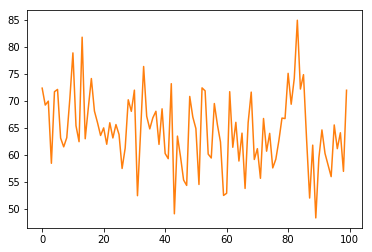

----
 Rr
cosl ?uoftu m be tirrl foeey wa d thrg they ooIe
;

T!clH-SA,
mTRs ,yhanrdeo dath sage lofrsins, poug soal thble magai 
brovesd swat thaNmti ulgin 
ro isuod my fusrean
dius inl,
at wore he:
Gerin'  
----
iter 100, loss 99.460876


In [ ]:
while True:
    # Try catch for interruption
    try:
        # Reset
        if p + T_steps >= len(data) or iteration == 0:
            g_h_prev = cp.zeros((H_size, 1))
            g_C_prev = cp.zeros((H_size, 1))
            p = 0


        inputs = [char_to_idx[ch] for ch in data[p: p + T_steps]]
        targets = [char_to_idx[ch] for ch in data[p + 1: p + T_steps + 1]]

        loss, g_h_prev, g_C_prev =  forward_backward(inputs, targets, g_h_prev, g_C_prev)
        smooth_loss = smooth_loss * 0.999 + loss * 0.001

        # Print every hundred steps
        if iteration % 100 == 0:
            update_status(inputs, g_h_prev, g_C_prev)


        # Update weights
        for param, dparam, mem in zip([W_f, W_i, W_C, W_o, W_y, b_f, b_i, b_C, b_o, b_y],
                                      [dW_f, dW_i, dW_C, dW_o, dW_y, db_f, db_i, db_C, db_o, db_y],
                                      [mW_f, mW_i, mW_C, mW_o, mW_y, mb_f, mb_i, mb_C, mb_o, mb_y]):
            mem += dparam * dparam # Calculate sum of gradients
            #print(learning_rate * dparam)
            param += -(learning_rate * dparam / cp.sqrt(mem + 1e-8))

        plot_iter = np.append(plot_iter, [iteration])
        plot_loss = np.append(plot_loss, [loss.get()])

        p += T_steps
        iteration += 1
    except KeyboardInterrupt:
        update_status(inputs, g_h_prev, g_C_prev)
        break